In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import numpy as np
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torchvision import transforms , datasets
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
transform = transforms.ToTensor()

In [5]:
train_data = datasets.MNIST(root=r"C:\Users\Zain\Desktop\Course\lec_9\datasets",train=True, download= True,transform=transform)

In [6]:
test_data = datasets.MNIST(root=r"C:\Users\Zain\Desktop\Course\lec_9\datasets",train=False, download= True,transform=transform)

In [7]:
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(train_data,batch_size=10,shuffle=False)

In [8]:
conv1 = nn.Conv2d(1,6,3,1) # (n_c , num of filters , f*f , Stride)

In [9]:
conv2 = nn.Conv2d(6,16,3,1)

In [10]:
for i,(X_train,y_train) in enumerate(train_data):
    break

In [11]:
X_train.shape

torch.Size([1, 28, 28])

In [12]:
x = X_train.view(1,1,28,28)

In [13]:
x= F.relu(conv1(x))

In [14]:
x.shape

torch.Size([1, 6, 26, 26])

In [15]:
x = F.max_pool2d(x,2,2) # (input, filter_size , stride)

In [17]:
x.shape

torch.Size([1, 6, 13, 13])

In [18]:
x = F.relu(conv2(x))

In [19]:
x.shape

torch.Size([1, 16, 11, 11])

In [20]:
x = F.max_pool2d(x,2,2)

In [21]:
x.shape

torch.Size([1, 16, 5, 5])

In [22]:
class ConvolutionalNetwork(nn.Module):
    def __init__ (self, in_sz =784, out_sz=10 , layers=[120,84]):
        super().__init__()
        
        
        self.conv1 = nn.Conv2d(1,6,3,1) # Z
        self.conv2 = nn.Conv2d(6,16,3,1) # Z
        
        self.fc1 = nn.Linear(5*5*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,X):
        X = F.relu(self.conv1(X)) #A1
        X = F.max_pool2d(X,2,2) #(input , Kernel , Stride)
        X = F.relu(self.conv2(X)) #A2
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,16*5*5) #Reshape
        X = F.relu(self.fc1(X)) #A3
        X = F.relu(self.fc2(X)) #A4
        X = self.fc3(X)
        
        return F.log_softmax(X,dim=1)
        

In [23]:
torch.manual_seed(42)
model= ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [24]:
for param in model.parameters():
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [26]:
import time

start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    for b,(X_train,y_train) in enumerate(train_loader):
        b+=1
        y_pred = model(X_train)
        loss = criterion(y_pred,y_train)
        
        
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%600 == 0:
            acc = trn_corr.item()*100/(10*b)
            print (f'Epoch {i} batch {b} loss: {loss.item()} accuracy:{acc}')
            
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    
    with torch.no_grad():
        for b , (X_test,y_test) in enumerate(test_loader):
            y_val = model(X_test)
            
            predicted = torch.max(y_val.data,1)[1]
            tst_corr += (predicted == y_test).sum()
    loss = criterion(y_val,y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
total_time = time.time() - start_time
print(f'Duration:{total_time/60} mins')

Epoch 0 batch 600 loss: 0.04255059361457825 accuracy:78.48333333333333
Epoch 0 batch 1200 loss: 0.07941822707653046 accuracy:85.825
Epoch 0 batch 1800 loss: 0.31659621000289917 accuracy:88.65555555555555
Epoch 0 batch 2400 loss: 0.01757170632481575 accuracy:90.4625
Epoch 0 batch 3000 loss: 0.006613250821828842 accuracy:91.6
Epoch 0 batch 3600 loss: 0.0016816820716485381 accuracy:92.44166666666666
Epoch 0 batch 4200 loss: 0.4883449077606201 accuracy:93.0952380952381
Epoch 0 batch 4800 loss: 0.018750842660665512 accuracy:93.55625
Epoch 0 batch 5400 loss: 0.011115724220871925 accuracy:93.98518518518519
Epoch 0 batch 6000 loss: 0.031585145741701126 accuracy:94.29333333333334
Epoch 1 batch 600 loss: 0.03976330906152725 accuracy:97.76666666666667
Epoch 1 batch 1200 loss: 0.043116144835948944 accuracy:97.88333333333334
Epoch 1 batch 1800 loss: 0.0016609022859483957 accuracy:97.85555555555555
Epoch 1 batch 2400 loss: 0.05149104446172714 accuracy:97.8
Epoch 1 batch 3000 loss: 0.1743337064981460

In [27]:
np_train_losses=[]
for i in train_losses:
    np_train_losses.append(i.detach().numpy())

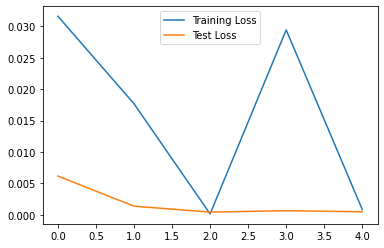

In [28]:
plt.plot(np_train_losses,label="Training Loss")
plt.plot(test_losses,label="Test Loss")
plt.legend()

In [29]:
train_acc = [t/600 for t in train_correct]
train_acc

[tensor(94.2933),
 tensor(97.9500),
 tensor(98.5217),
 tensor(98.8067),
 tensor(99.0383)]

In [30]:
test_acc = [t/600 for t in test_correct]
test_acc

[tensor(97.6317),
 tensor(98.4683),
 tensor(98.6750),
 tensor(99.2833),
 tensor(99.0367)]

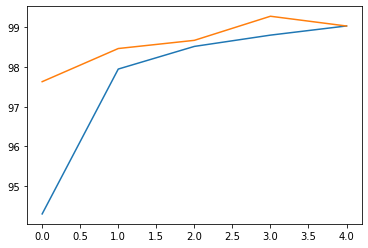

In [31]:
plt.plot(train_acc,label="Training Accuracy")
plt.plot(test_acc,label="Test Accuracy")

In [32]:
test_load_all = DataLoader(test_data,batch_size=10000)

In [33]:
with torch.no_grad():
    correct = 0
    for X_test,y_test in test_load_all:
        y_val = model(X_test)
            
        predicted = torch.max(y_val.data,1)[1]
        correct += (predicted == y_test).sum()

In [34]:
100*correct.item()/len(test_data)

98.56

In [35]:
confusion_matrix(predicted.view(-1),y_test.view(-1))

array([[ 972,    0,    1,    0,    0,    2,    4,    0,    4,    0],
       [   0, 1134,    3,    0,    2,    0,    5,   13,    2,    1],
       [   1,    0, 1021,    1,    1,    0,    2,    8,    2,    0],
       [   0,    1,    0,  999,    0,    6,    0,    0,    1,    0],
       [   0,    0,    1,    0,  978,    0,    3,    1,    2,   16],
       [   0,    0,    0,    4,    0,  876,    1,    0,    0,    5],
       [   4,    0,    0,    0,    1,    3,  942,    0,    0,    0],
       [   1,    0,    5,    3,    0,    1,    0, 1003,    1,    5],
       [   1,    0,    1,    3,    0,    2,    1,    1,  961,   12],
       [   1,    0,    0,    0,    0,    2,    0,    2,    1,  970]],
      dtype=int64)

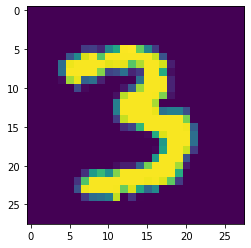

In [43]:
plt.imshow(test_data[500][0].reshape(28,28))

In [40]:
model.eval()
with torch.no_grad():
    new_prediction= model(test_data[500][0].view(1,1,28,28))

In [41]:
new_prediction

tensor([[-41.8147, -28.0974, -28.1067,   0.0000, -35.8653, -23.2801, -42.6333,
         -27.3693, -30.8485, -25.2737]])

In [42]:
new_prediction.argmax()

tensor(3)